In [6]:
import os
import numpy as np
from scipy.constants import c
from matplotlib import pyplot as plt

# Read data
data_root = os.path.join('/home/ming/Documents')
cur_case = '1018Aligned'
cur_scenario = 'distance_0.8m_0_1018figure1'

num_tx = 10
rbw = 50

data_path = os.path.join(data_root, cur_case, cur_scenario)
recording = np.load(os.path.join(data_path, "recording.npy"))
calibration = np.load(os.path.join(data_path, "calibration.npy"))
config = np.load(os.path.join(data_path, "config.npy"), allow_pickle=True).item()
doppler_nfft = recording.shape[0]
range_nfft = 512
angle_nfft = [64, 64]
data = recording

In [7]:
# For AoA and AoD, no need to use it now
# processed_data = data - data[0, :, :]
# range_profile = np.fft.ifft(processed_data, n=range_nfft, axis=2)
# processed_data_3d = processed_data.reshape(processed_data.shape[0], num_tx, 20, processed_data.shape[-1])
# processed_data_range = np.fft.ifft(processed_data_3d, n=range_nfft, axis=3)
# processed_data_3d_range = np.fft.fft2(processed_data_range, s=angle_nfft, axes=(1, 2))

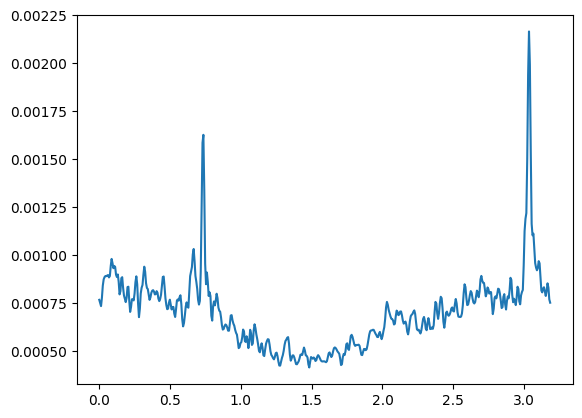

In [8]:
# Range Profile
processed_data = data - np.mean(recording[0:3, :, :], axis=0)
range_profile = np.fft.ifft(processed_data, n=range_nfft, axis=2)

freq = config['freq']
Ts = 1/range_nfft/(freq[1]-freq[0]+1e-16) # Avoid nan checks
time_vec = np.linspace(0,Ts*(range_nfft-1),num=range_nfft)
dist_vec = time_vec*(c/2) # distance in meters

range_profile_norm = np.linalg.norm(range_profile, axis=1)
range_profile_norm[np.isnan(range_profile_norm)] = 0

plt.figure()
plt.plot(dist_vec,range_profile_norm[30,:])
plt.show()

d 0.06271869897842407


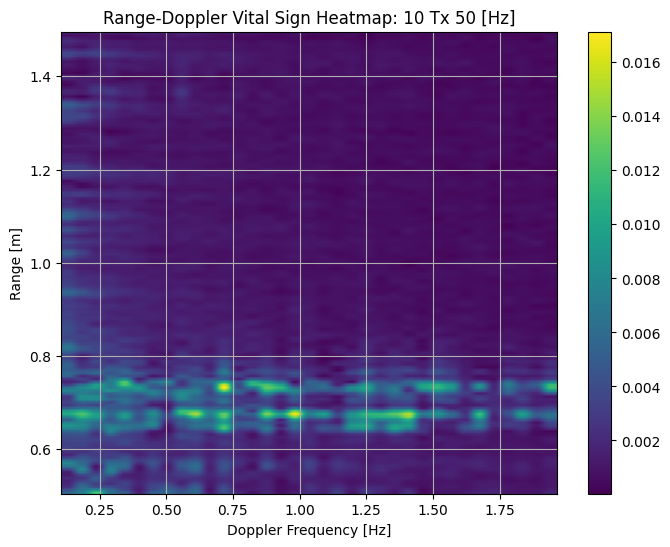

In [10]:
# Range-Doppler Profile
doppler = np.fft.fft(np.real(range_profile_norm), n=doppler_nfft,  axis=0)
doppler = doppler[0:len(doppler)//2,:]
doppler = np.abs(doppler.T)

d = config["sample_time"]
pulse_repetition_frequency = 1/d
print("d", d)
doppler_freq = np.fft.fftfreq(doppler_nfft,d)
doppler_freq = doppler_freq[doppler_freq>=0]

plt.figure(figsize=(8,6))
freq_low = np.where(doppler_freq>=0.1)[0][0]
freq_high = np.where(doppler_freq<=2.0)[0][-1]
range_low = np.where(dist_vec>=0.5)[0][0]
range_high = np.where(dist_vec<=1.5)[0][-1]

extent=[doppler_freq[freq_low],doppler_freq[freq_high],dist_vec[range_low],dist_vec[range_high]]
plt.imshow((doppler[range_low:range_high, freq_low:freq_high]), origin='lower', extent=extent, aspect='auto')
# plt.legend()
plt.colorbar()
plt.xlabel("Doppler Frequency [Hz]")
plt.ylabel("Range [m]")
plt.title(f"Range-Doppler Vital Sign Heatmap: {num_tx} Tx {rbw} [Hz]")
plt.grid()
plt.show()